<a href="https://colab.research.google.com/github/ShainiRose/DL-lab-7-part-ii/blob/main/LunarLander_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update -qq

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
!apt-get install -y -qq swig
!pip install -q gym==0.25.2

In [ ]:
# Try to install box2d-py; if it fails, try alternative Box2D packages
!pip install -q box2d-py || pip install -q Box2D || pip install -q box2d

# Install a newer pygame that builds reliably
!pip install -q pygame==2.5.2

# Confirm important packages
!python -c "import gym, torch, pygame; print('gym', gym.__version__, 'torch', torch.__version__, 'pygame', pygame.ver)"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 50.9 MB/s eta 0:00:00
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packag

In [ ]:
import numpy as np

# Patch for deprecated numpy.bool8
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_


In [ ]:
# Cell 2 — imports and small helpers
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

# Helper wrappers for Gym compatibility across versions
def safe_reset(env):
    res = env.reset()
    # gym v0.26 sometimes returns (obs, info)
    return res[0] if isinstance(res, tuple) else res

def safe_step(env, action):
    res = env.step(action)
    # gym v0.26 sometimes returns (obs, reward, terminated, truncated, info)
    if len(res) == 5:
        next_state, reward, terminated, truncated, info = res
        done = terminated or truncated
        return next_state, reward, done, info
    else:
        return res  # next_state, reward, done, info


In [ ]:
# Cell 3 — Replay buffer and model definitions
Transition = namedtuple('Transition', ('state','action','reward','next_state','done'))

class ReplayBuffer:
    def __init__(self, capacity=200000):
        self.buffer = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append(Transition(state,action,reward,next_state,done))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buffer)

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, action_dim)
        )
    def forward(self, x):
        return self.net(x)


In [ ]:
# Cell 4 — Training function (DQN with options)
def train_dqn_lunarlander(
    env_name='LunarLander-v2',
    episodes=600,
    gamma=0.99,
    lr=1e-3,
    batch_size=64,
    buffer_capacity=200000,
    start_training_after=1000,
    target_update_steps=1000,
    replay=True,
    use_target=True,
    eps_start=1.0,
    eps_end=0.01,
    eps_decay_episodes=500,
    max_steps_per_episode=1000,
    print_every=10,
    device=None
):
    # environment & device
    env = gym.make(env_name)
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    online_net = QNetwork(state_dim, action_dim).to(device)
    target_net = QNetwork(state_dim, action_dim).to(device)
    target_net.load_state_dict(online_net.state_dict())

    optimizer = optim.Adam(online_net.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    buffer = ReplayBuffer(capacity=buffer_capacity)

    total_steps = 0
    training_steps = 0
    rewards_history = []
    eps_history = []
    losses = []

    def epsilon_for_episode(ep):
        # linear decay from eps_start to eps_end over eps_decay_episodes
        frac = min(ep / float(eps_decay_episodes), 1.0)
        return eps_start + frac * (eps_end - eps_start)

    for ep in range(episodes):
        state = safe_reset(env)
        ep_reward = 0.0
        done = False
        eps = epsilon_for_episode(ep)
        step = 0

        while not done and step < max_steps_per_episode:
            total_steps += 1
            step += 1

            # action selection (epsilon-greedy)
            if random.random() < eps:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    s_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    qvals = online_net(s_t)
                    action = int(qvals.argmax(dim=1).item())

            # step env
            next_state, reward, done, info = safe_step(env, action)
            ep_reward += reward

            # push to buffer (always push; behaviour differs in 'replay' option later)
            buffer.push(state, action, reward, next_state, done)

            # training step
            if replay:
                # train from random batches sampled from buffer
                if len(buffer) >= batch_size and total_steps >= start_training_after:
                    trans = buffer.sample(batch_size)
                    states = torch.tensor(np.array(trans.state), dtype=torch.float32).to(device)
                    actions = torch.tensor(trans.action, dtype=torch.int64).unsqueeze(1).to(device)
                    rewards = torch.tensor(trans.reward, dtype=torch.float32).unsqueeze(1).to(device)
                    next_states = torch.tensor(np.array(trans.next_state), dtype=torch.float32).to(device)
                    dones = torch.tensor(trans.done, dtype=torch.float32).unsqueeze(1).to(device)

                    q_values = online_net(states).gather(1, actions)
                    with torch.no_grad():
                        if use_target:
                            q_next = target_net(next_states)
                        else:
                            q_next = online_net(next_states)
                        max_q_next = q_next.max(1)[0].unsqueeze(1)
                        targets = rewards + (1.0 - dones) * gamma * max_q_next

                    loss = loss_fn(q_values, targets)
                    optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(online_net.parameters(), 10.0)
                    optimizer.step()
                    losses.append(loss.item())
                    training_steps += 1
            else:
                # No replay: do an online (single-step) update using the latest transition
                if total_steps >= start_training_after:
                    s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    a = torch.tensor([[action]], dtype=torch.int64).to(device)
                    r = torch.tensor([[reward]], dtype=torch.float32).to(device)
                    ns = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)
                    d = float(done)

                    q_val = online_net(s).gather(1, a)
                    with torch.no_grad():
                        q_next = target_net(ns) if use_target else online_net(ns)
                        max_q_next = q_next.max(1)[0].unsqueeze(1)
                        target = r + (1.0 - d) * gamma * max_q_next

                    loss = loss_fn(q_val, target)
                    optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(online_net.parameters(), 10.0)
                    optimizer.step()
                    losses.append(loss.item())
                    training_steps += 1

            # target network update by steps
            if use_target and total_steps % target_update_steps == 0:
                target_net.load_state_dict(online_net.state_dict())

            state = next_state

        rewards_history.append(ep_reward)
        eps_history.append(eps)

        if (ep+1) % print_every == 0 or ep == 0:
            avg_last_10 = np.mean(rewards_history[-10:]) if len(rewards_history) >= 10 else np.mean(rewards_history)
            print(f"Ep {ep+1}/{episodes}  reward={ep_reward:.2f}  avg10={avg_last_10:.2f}  eps={eps:.3f}  buffer={len(buffer)}  losses_steps={len(losses)}")

    env.close()
    stats = {
        'rewards': rewards_history,
        'eps': eps_history,
        'losses': losses,
        'total_steps': total_steps,
        'training_steps': training_steps,
        'model': online_net
    }
    return stats


In [ ]:
# Cell 5 — Run two experiments and save stats
# NOTE: these runs can be long. Reduce episodes to test quickly.

# --- Experiment A: with Experience Replay + Target Network (recommended) ---
stats_replay_target = train_dqn_lunarlander(
    episodes=400,          # increase to 600+ for better convergence
    gamma=0.99,
    lr=1e-3,
    batch_size=64,
    buffer_capacity=200000,
    start_training_after=1000,
    target_update_steps=1000,
    replay=True,
    use_target=True,
    eps_start=1.0,
    eps_end=0.01,
    eps_decay_episodes=300,  # linear decay over first 300 episodes
    print_every=10
)

# --- Experiment B: without Replay & without Target Network (unstable comparison) ---
stats_no_replay_no_target = train_dqn_lunarlander(
    episodes=200,          # smaller, because this is slower and unstable
    gamma=0.99,
    lr=5e-4,
    batch_size=1,
    buffer_capacity=1,
    start_training_after=1,
    target_update_steps=10,
    replay=False,
    use_target=False,
    eps_start=1.0,
    eps_end=0.01,
    eps_decay_episodes=200,
    print_every=10
)


/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Ep 1/400  reward=-113.94  avg10=-113.94  eps=1.000  buffer=86  losses_steps=0
Ep 10/400  reward=-108.25  avg10=-111.81  eps=0.970  buffer=898  losses_steps=0
Ep 20/400  reward=-261.42  avg10=-210.99  eps=0.937  buffer=1838  losses_steps=839
Ep 30/400  reward=-152.59  avg10=-160.96  eps=0.904  buffer=2729  losses_steps=1730
Ep 40/400  reward=-76.33  avg10=-115.40  eps=0.871  buffer=3849  losses_steps=2850
Ep 50/400  reward=-77.32  avg10=-177.67  eps=0.838  buffer=4914  losses_steps=3915
Ep 60/400  reward=-86.15  avg10=-148.32  eps=0.805  buffer=6009  losses_steps=5010
Ep 70/400  reward=-49.32  avg10=-88.26  eps=0.772  buffer=7137  losses_steps=6138
Ep 80/400  reward=-125.54  avg10=-160.09  eps=0.739  buffer=8379  losses_steps=7380
Ep 90/400  reward=-293.79  avg10=-97.67  eps=0.706  buffer=9513  losses_steps=8514
Ep 100/400  reward=-118.49  avg10=-74.95  eps=0.673  buffer=10592  losses_steps=9593
Ep 110/400  reward=-119.32  avg10=-68.76  eps=0.640  buffer=11851  losses_steps=10852
Ep 120

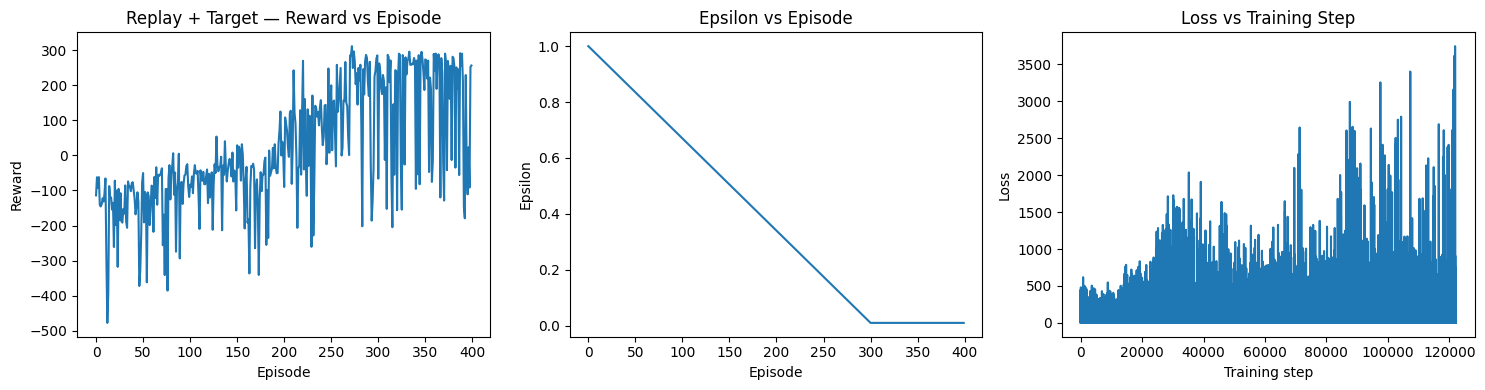

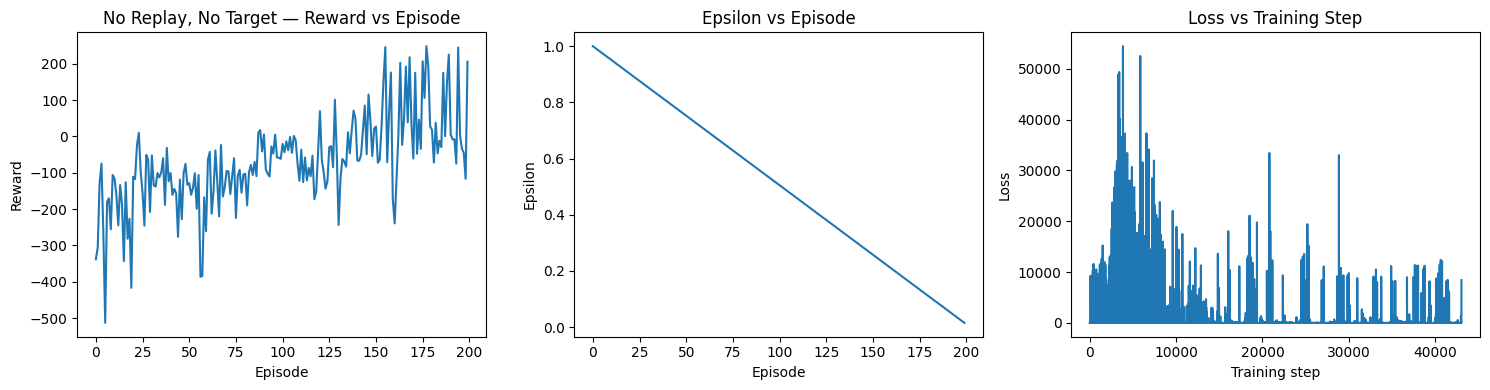

In [ ]:
# Cell 6 — plotting & quick evaluation

def plot_stats(stats, title="DQN run"):
    rewards = stats['rewards']
    eps = stats['eps']
    losses = stats['losses']

    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(f"{title} — Reward vs Episode")

    plt.subplot(1,3,2)
    plt.plot(eps)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Epsilon vs Episode")

    plt.subplot(1,3,3)
    if len(losses)>0:
        plt.plot(losses)
        plt.xlabel("Training step")
        plt.ylabel("Loss")
        plt.title("Loss vs Training Step")
    else:
        plt.text(0.1,0.5,"No loss steps recorded", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_stats(stats_replay_target, "Replay + Target")
plot_stats(stats_no_replay_no_target, "No Replay, No Target")


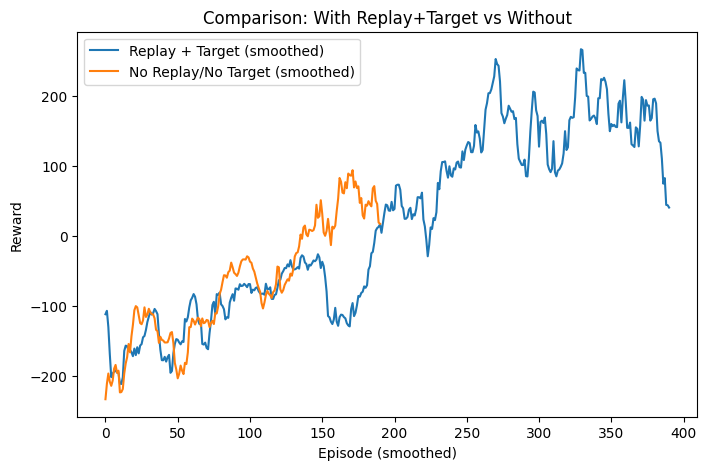

In [ ]:
# Compare reward curves (smoothed)
def moving_avg(x, w=10):
    return np.convolve(x, np.ones(w)/w, mode='valid')

r1 = stats_replay_target['rewards']
r2 = stats_no_replay_no_target['rewards']

plt.figure(figsize=(8,5))
if len(r1)>10:
    plt.plot(moving_avg(r1, w=10), label='Replay + Target (smoothed)')
else:
    plt.plot(r1, label='Replay + Target')
if len(r2)>10:
    plt.plot(moving_avg(r2, w=10), label='No Replay/No Target (smoothed)')
else:
    plt.plot(r2, label='No Replay/No Target')
plt.xlabel('Episode (smoothed)')
plt.ylabel('Reward')
plt.legend()
plt.title('Comparison: With Replay+Target vs Without')
plt.show()


In [ ]:
# Cell 7 — Evaluate a trained model (greedy)
def evaluate_model(model, env_name='LunarLander-v2', episodes=10, device=None, render=False):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = gym.make(env_name)
    total_rewards = []
    model.to(device)
    model.eval()
    for ep in range(episodes):
        state = safe_reset(env)
        done = False
        ep_r = 0.0
        while not done:
            s_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                action = int(model(s_t).argmax(dim=1).item())
            next_state, reward, done, info = safe_step(env, action)
            ep_r += reward
            state = next_state
            if render:
                env.render()
        total_rewards.append(ep_r)
    env.close()
    print(f"Eval over {episodes} episodes — mean reward: {np.mean(total_rewards):.2f}, std: {np.std(total_rewards):.2f}")
    return total_rewards

# Example (evaluate the replay+target model)
evaluate_model(stats_replay_target['model'], episodes=10)


Eval over 10 episodes — mean reward: 230.67, std: 124.48


[np.float64(272.0356991701686),
 np.float64(298.6742756268237),
 np.float64(-140.83483757262744),
 np.float64(266.898837599937),
 np.float64(254.04588418596938),
 np.float64(280.19664224261),
 np.float64(279.70965004455604),
 np.float64(255.67802178173415),
 np.float64(278.8443309415209),
 np.float64(261.40522019323447)]